**1. Setup**

In [1]:
# Install required package for TensorFlow
!pip install tensorflow

# Import TensorFlow and necessary modules for creating the NST model
import tensorflow as tf
from tensorflow.keras.applications import VGG19   # Pre-trained VGG19 model for feature extraction
from tensorflow.keras.models import Model         # To define custom models
import numpy as np                                # Numerical operations
import matplotlib.pyplot as plt                   # For displaying images
from PIL import Image                             # For image loading and processing


**2. Helper Functions**

In [2]:
# Function to load and preprocess images for the VGG19 model
def load_and_process_image(path, img_height=400):
    img = Image.open(path)                     # Open the image from the specified path
    img = img.resize((img_height, img_height)) # Resize image to a fixed square shape
    img = tf.keras.preprocessing.image.img_to_array(img) # Convert image to array format
    img = tf.expand_dims(img, axis=0)          # Add a batch dimension (required by the model)
    img = tf.keras.applications.vgg19.preprocess_input(img) # Preprocess image for VGG19
    return img

# Function to convert processed image back to displayable format
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))  # Remove batch dimension
    img[:, :, 0] += 103.939                             # Reverse VGG19 preprocessing steps for color channels
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]                               # Convert image from BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')          # Clip values and convert to uint8 for display
    return img


**3. Load Content and Style Images**

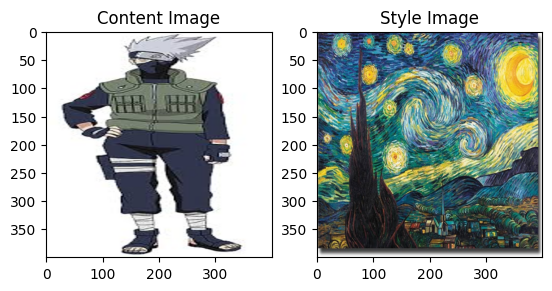

In [5]:
import requests
# Load your images (replace with your image paths)
content_image = load_and_process_image('/content/download.jpeg') # Load and process content image
style_image = load_and_process_image('/content/81hjf27YFHL._AC_UF894,1000_QL80_.jpg')     # Load and process style image

# Display both content and style images
plt.subplot(1, 2, 1)                    # Set up subplot for content image
plt.imshow(deprocess_image(content_image.numpy())) # Display content image
plt.title("Content Image")               # Set title for content image

plt.subplot(1, 2, 2)                    # Set up subplot for style image
plt.imshow(deprocess_image(style_image.numpy()))   # Display style image
plt.title("Style Image")                 # Set title for style image
plt.show()                               # Show both images


**4. Define NST Model and Extract Features**

In [6]:
# Define a model to extract content and style features from specific layers of VGG19
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet') # Load VGG19 without final classification layers
    vgg.trainable = False                              # Freeze VGG19 weights for feature extraction only
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] # Layers for style features
    content_layers = ['block5_conv2']                  # Layer for content features
    model_outputs = [vgg.get_layer(name).output for name in style_layers + content_layers] # Get outputs from specific layers
    return Model([vgg.input], model_outputs)           # Create new model for outputting these layer features

# Initialize the model
model = get_model()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**5. Extract Content and Style Features**

In [7]:
# Function to get content and style features from the model for given images
def get_feature_representations(model, content_img, style_img):
    content_outputs = model(content_img)               # Pass content image through model to get feature outputs
    style_outputs = model(style_img)                   # Pass style image through model to get feature outputs
    style_features = [style_layer for style_layer in style_outputs[:5]]  # Style features from first 5 layers
    content_features = content_outputs[5:]             # Content features from the last layer
    return style_features, content_features

# Extract style and content features
style_features, content_features = get_feature_representations(model, content_image, style_image)


**6. Calculate Style and Content Loss**

In [8]:
# Function to compute content loss between base content and target
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target)) # Mean squared error for content loss

# # Function to compute Gram matrix for style feature maps
# def gram_matrix(input_tensor):
#     result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Calculate outer product of features
#     input_shape = tf.shape(input_tensor)
#     num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)   # Number of spatial locations
#     return result / num_locations                                          # Normalize Gram matrix by number of locations

# Function to compute style loss between base style and target style Gram matrices
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()             # Get shape for normalization
    gram_style = gram_matrix(base_style)                                   # Calculate Gram matrix for base style
    return tf.reduce_mean(tf.square(gram_style - gram_target))             # Mean squared error for style loss


In [11]:
# Function to compute Gram matrix for style feature maps
def gram_matrix(input_tensor):
    # Add a batch dimension if it's missing
    if len(input_tensor.shape) == 3:  # Check if rank is 3
        input_tensor = tf.expand_dims(input_tensor, axis=0)  # Add batch dimension

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Calculate outer product of features
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)   # Number of spatial locations
    return result / num_locations                                          # Normalize Gram matrix by number of locations

**7. Define Total Loss**

In [12]:
# Function to compute total loss as a combination of content and style losses
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights                   # Unpack weights for style and content
    model_outputs = model(init_image)                             # Pass generated image through model for features

    style_output_features = model_outputs[:5]                     # Extract style features from model outputs
    content_output_features = model_outputs[5:]                   # Extract content features from model outputs

    style_score = 0                                               # Initialize style score
    content_score = 0                                             # Initialize content score

    # Calculate style loss for each style layer
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += get_style_loss(comb_style[0], target_style)

    # Calculate content loss for content layer
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += get_content_loss(comb_content[0], target_content)

    # Adjust losses by their weights and average
    style_score *= style_weight / len(gram_style_features)
    content_score *= content_weight / len(content_features)

    # Total loss is sum of style and content losses
    loss = style_score + content_score
    return loss


**8. Optimize and Generate the Stylized Image**

In [13]:
# Set up parameters for optimization
content_weight = 1e3                                 # Weight for content loss
style_weight = 1e-2                                  # Weight for style loss
loss_weights = (style_weight, content_weight)        # Pack weights for easier access
num_iterations = 1000                                # Number of optimization steps
init_image = tf.Variable(content_image, dtype=tf.float32) # Initialize generated image as content image

# Define optimizer for the NST optimization
opt = tf.optimizers.Adam(learning_rate=5.0)

# Calculate Gram matrices for style features to use as targets
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

# Function to compute gradients of total loss with respect to generated image
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:                          # Gradient tape to record operations
        all_loss = compute_loss(**cfg)                       # Calculate total loss
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss # Compute and return gradients

# Run optimization loop
for i in range(num_iterations):
    grads, all_loss = compute_grads({
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    })
    opt.apply_gradients([(grads, init_image)])               # Apply gradients to update generated image
    if i % 100 == 0:                                         # Print loss every 100 iterations
        print(f"Iteration {i}: loss {all_loss:.4f}")


Iteration 0: loss 511275872.0000
Iteration 100: loss 5071887.5000
Iteration 200: loss 3270113.0000
Iteration 300: loss 2666957.5000
Iteration 400: loss 2350326.5000
Iteration 500: loss 2294938.0000
Iteration 600: loss 2055513.1250
Iteration 700: loss 1920533.3750
Iteration 800: loss 1861079.5000
Iteration 900: loss 1859911.2500


**9. Display Final Stylized Image**

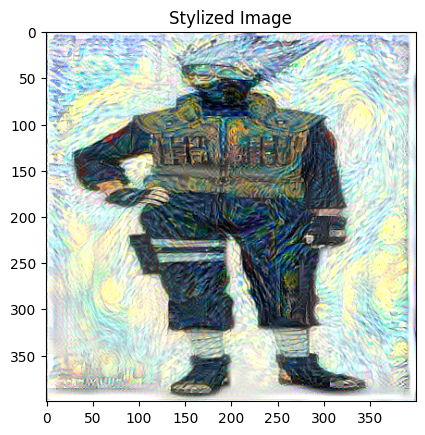

In [14]:
# Display the final stylized image after optimization
final_img = deprocess_image(init_image.numpy())              # Convert generated image to displayable format
plt.imshow(final_img)                                        # Display image
plt.title("Stylized Image")                                  # Set title
plt.show()                                                   # Show the plot
